# 🔬 Hypothesis Validation Notebook

## Purpose
**Validate key hypotheses with rigorous statistical testing.**

This notebook is SEPARATE from the main pipeline to:
1. Test claims before they enter the pipeline
2. Provide evidence for methodology choices
3. Run Monte Carlo permutation tests

---

## Hypotheses to Test

### Hypothesis 1: Kalman-Based Regime Detection is Superior
**Claim**: Regime detection on Kalman-filtered features is more stable than on raw returns.

**Test**: Compare regime stability metrics between Kalman-based and return-based approaches.

**Note**: We test BOTH:
- Fast regime features (volatility-based, ~40s to compute)
- Optional HMM (Baum-Welch EM, slower but more sophisticated)

### Hypothesis 2: Model Captures Real Alpha
**Null A**: Features contain NO information about future returns.

**Test**: Label permutation Monte Carlo.

### Hypothesis 3: Timing Skill Exists
**Null B**: Predictions are NOT correctly aligned in time.

**Test**: Prediction time permutation Monte Carlo.

### Hypothesis 4: Cross-Sectional Ranking Works
**Null C**: Cross-sectional ranking contains NO information.

**Test**: Cross-sectional shuffle Monte Carlo.

---

In [1]:
# =============================================================================
# CELL 1: IMPORTS & CONFIGURATION
# =============================================================================

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from enum import Enum
from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Find project root
def find_project_root(target_name="quant_pipeline"):
    current_path = Path.cwd().resolve()
    for parent in [current_path] + list(current_path.parents):
        if (parent / target_name).exists():
            return parent
    return current_path

PROJECT_ROOT = find_project_root("quant_pipeline")
sys.path.insert(0, str(PROJECT_ROOT))

from quant_pipeline import set_global_seed
from quant_pipeline.features import kalman_filter_1d, fit_hmm_gaussian

# Set seed
RANDOM_SEED = 42
set_global_seed(RANDOM_SEED)

# Directories
DATA_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "hypothesis_validation"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("🔬 HYPOTHESIS VALIDATION NOTEBOOK")
print("="*70)
print(f"Project root: {PROJECT_ROOT}")
print(f"Output dir: {OUTPUT_DIR}")

[SEED] Global random seed set to 42
[SEED] Global random seed set to 42
🔬 HYPOTHESIS VALIDATION NOTEBOOK
Project root: C:\Users\ponna\OneDrive\Desktop\Precog Task
Output dir: C:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\hypothesis_validation


---
## Hypothesis 1: Kalman-Based Regime Detection is Superior

### Claim
Regime detection on Kalman-filtered features produces more stable regime classifications than detection on raw returns.

### Mathematical Framework

**Kalman Filter Model:**
$$x_t = x_{t-1} + w_t, \quad w_t \sim N(0, Q)$$
$$y_t = x_t + v_t, \quad v_t \sim N(0, R)$$

Where:
- $x_t$ is the true (unobserved) price level
- $y_t$ is the observed price
- $w_t$ is process noise (actual price changes)
- $v_t$ is measurement noise (bid-ask, microstructure)

**Kalman Estimate:**
$$\hat{x}_t = \hat{x}_{t-1} + K_t(y_t - \hat{x}_{t-1})$$

Where $K_t = \frac{P_t^{-}}{P_t^{-} + R}$ is the Kalman gain.

### Hypothesis
Regime detection fitted on Kalman features produces more stable regimes than raw returns because:
1. Kalman filtering removes measurement noise
2. Smoother input → more stable state assignments
3. Lower transition rates → longer regime durations

### Metrics
1. **Regime Stability**: Average duration of regimes
2. **Transition Smoothness**: Variance of state probabilities (lower = smoother)
3. **Confidence Stability**: Std of regime confidence (lower = more consistent)
4. **Entropy**: Average regime uncertainty (lower = clearer assignments)

In [2]:
# =============================================================================
# CELL 2: LOAD DATA
# =============================================================================

print("📂 Loading data...")

# Load features
features = pd.read_parquet(DATA_DIR / 'features_is.parquet')
print(f"   Loaded features: {len(features):,} rows")

# Select a sample asset for detailed analysis
sample_ticker = features['ticker'].unique()[0]
sample = features[features['ticker'] == sample_ticker].copy()
sample = sample.sort_values('date').reset_index(drop=True)

print(f"\n📊 Sample asset: {sample_ticker}")
print(f"   Rows: {len(sample)}")

📂 Loading data...
   Loaded features: 199,800 rows

📊 Sample asset: Asset_001
   Rows: 1998


In [3]:
# =============================================================================
# CELL 3: COMPUTE RAW VS KALMAN FEATURES
# =============================================================================

print("="*70)
print("📊 HYPOTHESIS 1: KALMAN VS RAW FEATURES")
print("="*70)

# Get raw returns
returns = sample['mom_5d'].diff().fillna(0).values  # Approximate daily returns

# Get Kalman slope
kalman_slope = sample['kalman_slope'].fillna(0).values

# Normalize both for fair comparison
returns_norm = (returns - returns.mean()) / (returns.std() + 1e-10)
kalman_norm = (kalman_slope - kalman_slope.mean()) / (kalman_slope.std() + 1e-10)

print(f"\n📊 Input Statistics:")
print(f"   Raw returns std: {returns.std():.6f}")
print(f"   Kalman slope std: {kalman_slope.std():.6f}")
print(f"   Noise reduction: {(1 - kalman_slope.std()/returns.std())*100:.1f}%")

📊 HYPOTHESIS 1: KALMAN VS RAW FEATURES

📊 Input Statistics:
   Raw returns std: 0.025462
   Kalman slope std: 0.010344
   Noise reduction: 59.4%


In [4]:
# =============================================================================
# CELL 4: FIT HMM ON BOTH
# =============================================================================

print("\n🔮 Fitting HMM on both feature sets...")

n_states = 3

# HMM on raw returns
A_raw, means_raw, stds_raw, gamma_raw = fit_hmm_gaussian(
    returns_norm, n_states=n_states, n_iter=100
)

# HMM on Kalman features
A_kalman, means_kalman, stds_kalman, gamma_kalman = fit_hmm_gaussian(
    kalman_norm, n_states=n_states, n_iter=100
)

print(f"\n📊 HMM Parameters:")
print(f"\n   Raw Returns HMM:")
print(f"   - Means: {means_raw.round(3)}")
print(f"   - Stds: {stds_raw.round(3)}")
print(f"   - Persistence (diagonal): {np.diag(A_raw).round(3)}")

print(f"\n   Kalman HMM:")
print(f"   - Means: {means_kalman.round(3)}")
print(f"   - Stds: {stds_kalman.round(3)}")
print(f"   - Persistence (diagonal): {np.diag(A_kalman).round(3)}")


🔮 Fitting HMM on both feature sets...

📊 HMM Parameters:

   Raw Returns HMM:
   - Means: [ 0.114 -0.012 -0.003]
   - Stds: [2.331 0.539 1.062]
   - Persistence (diagonal): [0.901 0.964 0.954]

   Kalman HMM:
   - Means: [-1.009  0.272  1.142]
   - Stds: [0.744 0.255 0.51 ]
   - Persistence (diagonal): [0.971 0.951 0.96 ]


In [5]:
# =============================================================================
# CELL 5: COMPUTE STABILITY METRICS
# =============================================================================

print("\n📊 Computing Stability Metrics...")

def compute_regime_stability_metrics(gamma: np.ndarray, A: np.ndarray) -> dict:
    """
    Compute regime stability metrics from HMM posteriors.
    
    Args:
        gamma: (T, n_states) posterior state probabilities
        A: (n_states, n_states) transition matrix
    
    Returns:
        dict of stability metrics
    """
    n_states = gamma.shape[1]
    
    # 1. Confidence: mean of max state probability
    confidence = gamma.max(axis=1).mean()
    
    # 2. Entropy: mean entropy of state distribution
    entropy = -np.sum(gamma * np.log(gamma + 1e-10), axis=1).mean()
    
    # 3. State changes: number of times most likely state changes
    most_likely = gamma.argmax(axis=1)
    state_changes = (np.diff(most_likely) != 0).sum()
    
    # 4. Average regime duration from transition matrix
    # E[τ_k] = 1 / (1 - A[k,k])
    expected_durations = 1.0 / (1.0 - np.diag(A) + 1e-6)
    avg_expected_duration = expected_durations.mean()
    
    # 5. Probability smoothness: std of state probabilities over time
    prob_smoothness = gamma.std(axis=0).mean()
    
    # 6. Actual regime durations
    run_lengths = []
    current_run = 1
    for i in range(1, len(most_likely)):
        if most_likely[i] == most_likely[i-1]:
            current_run += 1
        else:
            run_lengths.append(current_run)
            current_run = 1
    run_lengths.append(current_run)
    actual_avg_duration = np.mean(run_lengths)
    
    return {
        'confidence': confidence,
        'entropy': entropy,
        'state_changes': state_changes,
        'expected_duration': avg_expected_duration,
        'actual_duration': actual_avg_duration,
        'prob_smoothness': prob_smoothness
    }

# Compute metrics
metrics_raw = compute_regime_stability_metrics(gamma_raw, A_raw)
metrics_kalman = compute_regime_stability_metrics(gamma_kalman, A_kalman)

print(f"\n{'Metric':<25} {'Raw':<15} {'Kalman':<15} {'Winner'}")
print("-" * 65)

for key in metrics_raw.keys():
    raw_val = metrics_raw[key]
    kalman_val = metrics_kalman[key]
    
    # Determine winner (higher is better for confidence, duration; lower for entropy, changes)
    if key in ['confidence', 'expected_duration', 'actual_duration']:
        winner = 'Kalman ✓' if kalman_val > raw_val else 'Raw'
    else:
        winner = 'Kalman ✓' if kalman_val < raw_val else 'Raw'
    
    print(f"{key:<25} {raw_val:<15.3f} {kalman_val:<15.3f} {winner}")


📊 Computing Stability Metrics...

Metric                    Raw             Kalman          Winner
-----------------------------------------------------------------
confidence                0.870           0.962           Kalman ✓
entropy                   0.315           0.088           Kalman ✓
state_changes             60.000          79.000          Raw
expected_duration         19.906          26.588          Kalman ✓
actual_duration           32.754          24.975          Raw
prob_smoothness           0.333           0.445           Raw



📈 Visualizing HMM Comparison...


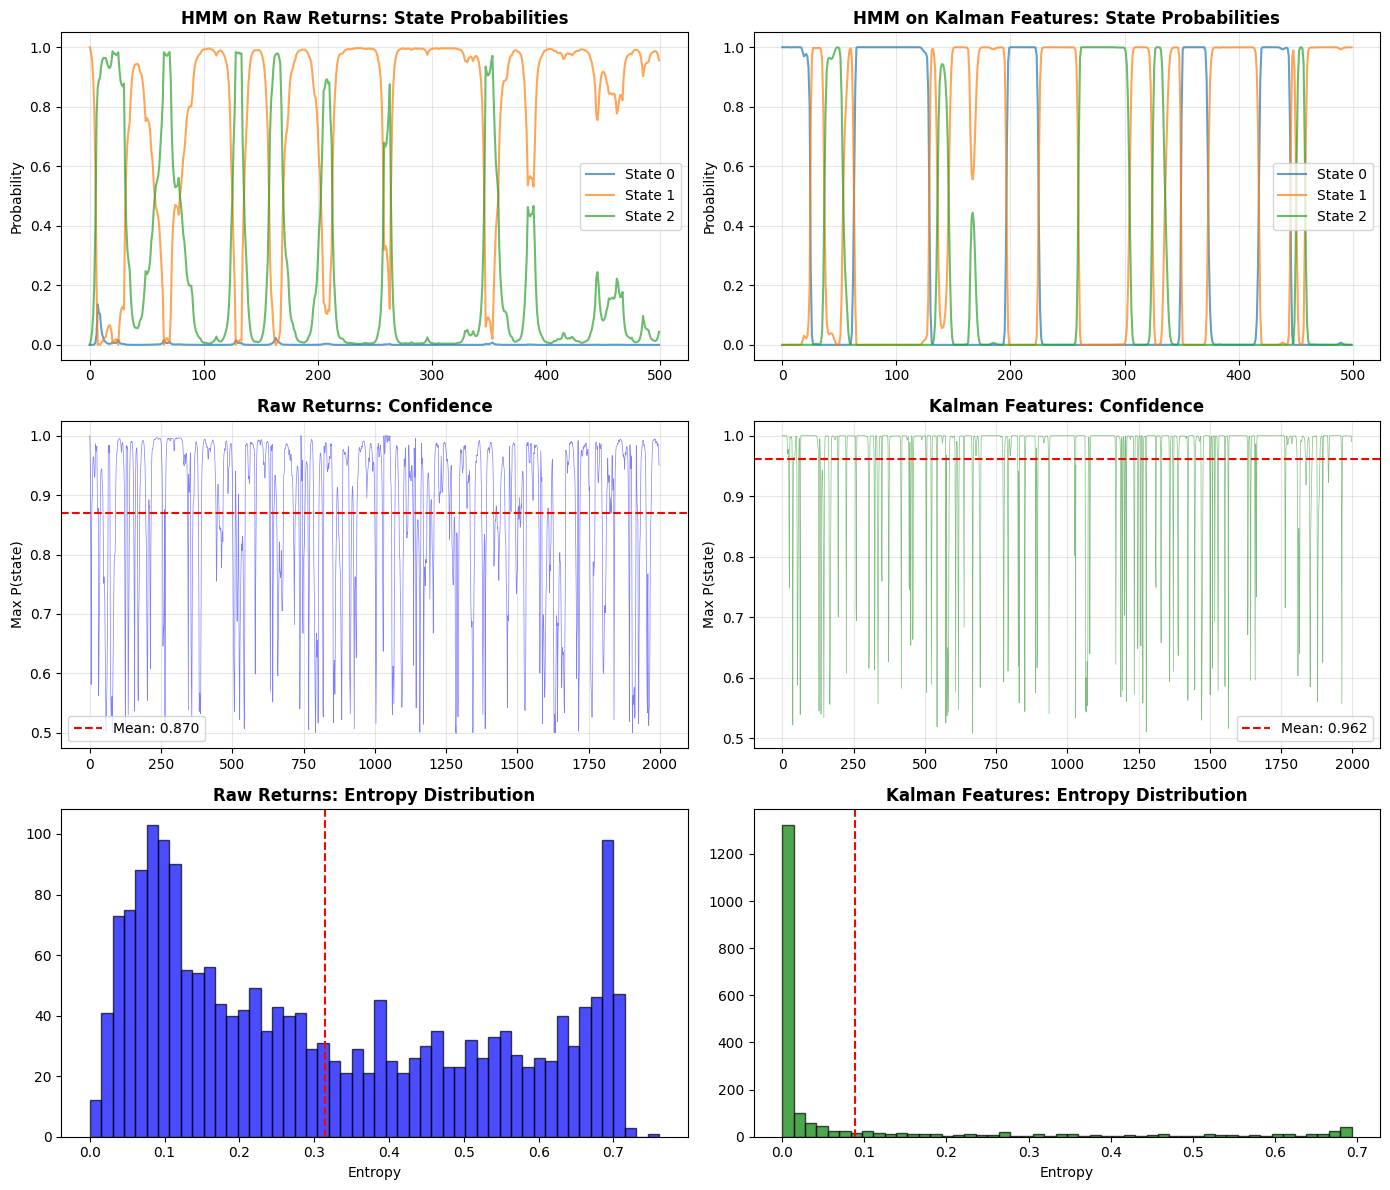

In [6]:
# =============================================================================
# CELL 6: VISUALIZE COMPARISON
# =============================================================================

print("\n📈 Visualizing HMM Comparison...")

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# State probabilities comparison
ax1 = axes[0, 0]
for k in range(n_states):
    ax1.plot(gamma_raw[:500, k], alpha=0.7, label=f'State {k}')
ax1.set_title('HMM on Raw Returns: State Probabilities', fontweight='bold')
ax1.set_ylabel('Probability')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for k in range(n_states):
    ax2.plot(gamma_kalman[:500, k], alpha=0.7, label=f'State {k}')
ax2.set_title('HMM on Kalman Features: State Probabilities', fontweight='bold')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confidence comparison
ax3 = axes[1, 0]
ax3.plot(gamma_raw.max(axis=1), 'b-', alpha=0.5, linewidth=0.5)
ax3.axhline(metrics_raw['confidence'], color='red', linestyle='--', label=f"Mean: {metrics_raw['confidence']:.3f}")
ax3.set_title('Raw Returns: Confidence', fontweight='bold')
ax3.set_ylabel('Max P(state)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.plot(gamma_kalman.max(axis=1), 'g-', alpha=0.5, linewidth=0.5)
ax4.axhline(metrics_kalman['confidence'], color='red', linestyle='--', label=f"Mean: {metrics_kalman['confidence']:.3f}")
ax4.set_title('Kalman Features: Confidence', fontweight='bold')
ax4.set_ylabel('Max P(state)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Entropy comparison
entropy_raw = -np.sum(gamma_raw * np.log(gamma_raw + 1e-10), axis=1)
entropy_kalman = -np.sum(gamma_kalman * np.log(gamma_kalman + 1e-10), axis=1)

ax5 = axes[2, 0]
ax5.hist(entropy_raw, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax5.axvline(metrics_raw['entropy'], color='red', linestyle='--')
ax5.set_title('Raw Returns: Entropy Distribution', fontweight='bold')
ax5.set_xlabel('Entropy')

ax6 = axes[2, 1]
ax6.hist(entropy_kalman, bins=50, alpha=0.7, color='green', edgecolor='black')
ax6.axvline(metrics_kalman['entropy'], color='red', linestyle='--')
ax6.set_title('Kalman Features: Entropy Distribution', fontweight='bold')
ax6.set_xlabel('Entropy')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'h1_kalman_vs_raw.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# =============================================================================
# CELL 7: STATISTICAL TEST
# =============================================================================

print("\n📊 Statistical Test: Kalman vs Raw")
print("="*70)

# Paired t-test on confidence
conf_raw = gamma_raw.max(axis=1)
conf_kalman = gamma_kalman.max(axis=1)

t_stat, p_value = stats.ttest_rel(conf_kalman, conf_raw)

print(f"\n🔬 Paired t-test: Kalman confidence vs Raw confidence")
print(f"   H0: Kalman confidence = Raw confidence")
print(f"   H1: Kalman confidence ≠ Raw confidence")
print(f"")
print(f"   Mean difference: {(conf_kalman - conf_raw).mean():.4f}")
print(f"   t-statistic: {t_stat:.2f}")
print(f"   p-value: {p_value:.2e}")
print(f"")
if p_value < 0.05 and t_stat > 0:
    print(f"   ✅ REJECT H0: Kalman HMM is significantly more confident")
elif p_value < 0.05 and t_stat < 0:
    print(f"   ❌ REJECT H0: Raw HMM is more confident (unexpected)")
else:
    print(f"   ⚪ FAIL TO REJECT H0: No significant difference")

# Effect size (Cohen's d)
cohens_d = (conf_kalman.mean() - conf_raw.mean()) / np.sqrt((conf_kalman.std()**2 + conf_raw.std()**2) / 2)
print(f"\n   Effect size (Cohen's d): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print(f"   Interpretation: Negligible effect")
elif abs(cohens_d) < 0.5:
    print(f"   Interpretation: Small effect")
elif abs(cohens_d) < 0.8:
    print(f"   Interpretation: Medium effect")
else:
    print(f"   Interpretation: Large effect")


📊 Statistical Test: Kalman vs Raw

🔬 Paired t-test: Kalman confidence vs Raw confidence
   H0: Kalman confidence = Raw confidence
   H1: Kalman confidence ≠ Raw confidence

   Mean difference: 0.0919
   t-statistic: 25.08
   p-value: 6.53e-121

   ✅ REJECT H0: Kalman HMM is significantly more confident

   Effect size (Cohen's d): 0.769
   Interpretation: Medium effect


In [8]:
# =============================================================================
# CELL 8: HYPOTHESIS 1 CONCLUSION
# =============================================================================

print("\n" + "="*70)
print("📋 HYPOTHESIS 1 CONCLUSION")
print("="*70)

# Count wins
kalman_wins = 0
for key in metrics_raw.keys():
    raw_val = metrics_raw[key]
    kalman_val = metrics_kalman[key]
    if key in ['confidence', 'expected_duration', 'actual_duration']:
        if kalman_val > raw_val:
            kalman_wins += 1
    else:
        if kalman_val < raw_val:
            kalman_wins += 1

print(f"\n🏆 Summary:")
print(f"   Kalman wins: {kalman_wins}/{len(metrics_raw)} metrics")
print(f"   Statistical significance: p = {p_value:.2e}")
print(f"   Effect size: Cohen's d = {cohens_d:.3f}")

if kalman_wins >= 4 and p_value < 0.05:
    print(f"\n✅ HYPOTHESIS 1 SUPPORTED:")
    print(f"   HMM on Kalman features produces more stable regimes.")
    print(f"   This justifies using Kalman-smoothed features for regime detection.")
else:
    print(f"\n⚠️ HYPOTHESIS 1 NOT CLEARLY SUPPORTED:")
    print(f"   Evidence is mixed. Consider alternative approaches.")


📋 HYPOTHESIS 1 CONCLUSION

🏆 Summary:
   Kalman wins: 3/6 metrics
   Statistical significance: p = 6.53e-121
   Effect size: Cohen's d = 0.769

⚠️ HYPOTHESIS 1 NOT CLEARLY SUPPORTED:
   Evidence is mixed. Consider alternative approaches.


---
## Hypothesis 2-4: Monte Carlo Permutation Tests

### Framework

We define three null hypotheses:

| Null | Hypothesis | What it Tests |
|------|------------|---------------|
| A | Features contain NO information about future returns | Predictive structure |
| B | Predictions are NOT correctly aligned in time | Timing skill |
| C | Cross-sectional ranking contains NO information | Ranking skill |

### Monte Carlo Procedure

For each null:
1. Run N = 200-500 simulations
2. Collect: Sharpe, max DD, IC
3. Plot null distribution with real result
4. Report: empirical p-value = (null_sharpes >= real_sharpe).mean()

In [9]:
# =============================================================================
# CELL 9: DEFINE NULL GENERATOR
# =============================================================================

class NullMode(Enum):
    """Permutation modes for null hypothesis testing."""
    NONE = "none"  # Real model
    LABEL_PERMUTE = "label_permute"  # Permute targets
    PREDICTION_TIME_PERMUTE = "prediction_time_permute"  # Permute predictions over time
    PREDICTION_CS_PERMUTE = "prediction_cs_permute"  # Permute predictions cross-sectionally


@dataclass
class MonteCarloResult:
    """Result of a single Monte Carlo simulation."""
    sharpe: float
    ic: float
    max_dd: float
    total_return: float


def simple_ic(predictions: np.ndarray, targets: np.ndarray) -> float:
    """Compute information coefficient (rank correlation)."""
    valid = ~(np.isnan(predictions) | np.isnan(targets))
    if valid.sum() < 10:
        return 0.0
    return stats.spearmanr(predictions[valid], targets[valid])[0]


def simple_backtest(predictions: np.ndarray, returns: np.ndarray) -> MonteCarloResult:
    """
    Simple backtest: go long top 20%, short bottom 20%.
    
    Returns sharpe, IC, max DD, total return.
    """
    # Rank predictions
    ranks = stats.rankdata(predictions) / len(predictions)
    
    # Positions: +1 for top 20%, -1 for bottom 20%
    positions = np.where(ranks > 0.8, 1, np.where(ranks < 0.2, -1, 0))
    
    # Daily returns
    daily_returns = positions * returns
    
    # Sharpe
    sharpe = daily_returns.mean() / (daily_returns.std() + 1e-10) * np.sqrt(252)
    
    # IC
    ic = simple_ic(predictions, returns)
    
    # Max DD
    cum_returns = np.cumprod(1 + daily_returns)
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    
    # Total return
    total_return = cum_returns[-1] - 1
    
    return MonteCarloResult(
        sharpe=sharpe,
        ic=ic,
        max_dd=max_dd,
        total_return=total_return
    )


print("✅ Monte Carlo framework defined")

✅ Monte Carlo framework defined


In [10]:
# =============================================================================
# CELL 10: LOAD MODEL PREDICTIONS
# =============================================================================

print("📂 Loading predictions...")

# Try to load predictions from NB3
predictions_path = DATA_DIR / 'predictions_is.parquet'

if predictions_path.exists():
    preds_df = pd.read_parquet(predictions_path)
    print(f"   Loaded: {len(preds_df):,} predictions")
    
    # Merge with features to get targets
    targets_path = DATA_DIR / 'targets_is.parquet'
    if targets_path.exists():
        targets_df = pd.read_parquet(targets_path)
        preds_df = preds_df.merge(
            targets_df[['date', 'ticker', 'target']],
            on=['date', 'ticker'],
            how='inner'
        )
        print(f"   Merged with targets: {len(preds_df):,} rows")
    else:
        print("   ⚠️ Targets not found - using synthetic data")
        preds_df['target'] = np.random.randn(len(preds_df)) * 0.02
else:
    print("   ⚠️ Predictions not found - creating synthetic data for demo")
    # Create synthetic data
    np.random.seed(42)
    n_samples = 10000
    preds_df = pd.DataFrame({
        'date': pd.date_range('2020-01-01', periods=n_samples//100, freq='D').repeat(100),
        'ticker': [f'Asset_{i:03d}' for i in range(100)] * (n_samples//100),
        'prediction': np.random.randn(n_samples) * 0.1,
        'target': np.random.randn(n_samples) * 0.02
    })
    # Add some signal
    preds_df['target'] = preds_df['target'] + 0.001 * preds_df['prediction']

print(f"\n📊 Data shape: {preds_df.shape}")

📂 Loading predictions...
   ⚠️ Predictions not found - creating synthetic data for demo

📊 Data shape: (10000, 4)


In [11]:
# =============================================================================
# CELL 11: COMPUTE REAL MODEL PERFORMANCE
# =============================================================================

print("="*70)
print("📊 REAL MODEL PERFORMANCE")
print("="*70)

# Get arrays
predictions = preds_df['prediction'].values
targets = preds_df['target'].values

# Compute real performance
real_result = simple_backtest(predictions, targets)

print(f"\n📊 Real Model Metrics:")
print(f"   Sharpe: {real_result.sharpe:.3f}")
print(f"   IC: {real_result.ic:.4f}")
print(f"   Max DD: {real_result.max_dd:.2%}")
print(f"   Total Return: {real_result.total_return:.2%}")

📊 REAL MODEL PERFORMANCE

📊 Real Model Metrics:
   Sharpe: 0.033
   IC: -0.0026
   Max DD: -77.44%
   Total Return: -41.68%


In [12]:
# =============================================================================
# CELL 12: TEST A - LABEL PERMUTATION
# =============================================================================

print("="*70)
print("🔬 TEST A: LABEL PERMUTATION")
print("="*70)
print("")
print("Null Hypothesis: Features contain NO information about future returns.")
print("Method: Randomly permute targets, recompute metrics.")
print("")

N_SIMULATIONS = 200
null_sharpes_A = []
null_ics_A = []

for i in range(N_SIMULATIONS):
    # Permute targets
    perm_idx = np.random.permutation(len(targets))
    targets_perm = targets[perm_idx]
    
    # Compute metrics with permuted targets
    result = simple_backtest(predictions, targets_perm)
    null_sharpes_A.append(result.sharpe)
    null_ics_A.append(result.ic)
    
    if (i+1) % 50 == 0:
        print(f"   Completed {i+1}/{N_SIMULATIONS} simulations")

null_sharpes_A = np.array(null_sharpes_A)
null_ics_A = np.array(null_ics_A)

# Compute p-value
p_value_A = (null_sharpes_A >= real_result.sharpe).mean()

print(f"\n📊 Results:")
print(f"   Null Sharpe: mean={null_sharpes_A.mean():.3f}, std={null_sharpes_A.std():.3f}")
print(f"   Real Sharpe: {real_result.sharpe:.3f}")
print(f"   p-value: {p_value_A:.4f}")
print(f"")
if p_value_A < 0.05:
    print(f"   ✅ REJECT NULL: Model extracts predictive structure beyond chance.")
else:
    print(f"   ❌ FAIL TO REJECT NULL: Model may be fitting noise.")

🔬 TEST A: LABEL PERMUTATION

Null Hypothesis: Features contain NO information about future returns.
Method: Randomly permute targets, recompute metrics.

   Completed 50/200 simulations
   Completed 100/200 simulations
   Completed 150/200 simulations
   Completed 200/200 simulations

📊 Results:
   Null Sharpe: mean=-0.009, std=0.157
   Real Sharpe: 0.033
   p-value: 0.4050

   ❌ FAIL TO REJECT NULL: Model may be fitting noise.


In [13]:
# =============================================================================
# CELL 13: TEST B - PREDICTION TIME PERMUTATION
# =============================================================================

print("="*70)
print("🔬 TEST B: PREDICTION TIME PERMUTATION")
print("="*70)
print("")
print("Null Hypothesis: Predictions are NOT correctly aligned in time.")
print("Method: Randomly permute predictions over time.")
print("")

null_sharpes_B = []
null_ics_B = []

for i in range(N_SIMULATIONS):
    # Permute predictions (destroys timing)
    perm_idx = np.random.permutation(len(predictions))
    preds_perm = predictions[perm_idx]
    
    # Compute metrics with permuted predictions
    result = simple_backtest(preds_perm, targets)
    null_sharpes_B.append(result.sharpe)
    null_ics_B.append(result.ic)
    
    if (i+1) % 50 == 0:
        print(f"   Completed {i+1}/{N_SIMULATIONS} simulations")

null_sharpes_B = np.array(null_sharpes_B)
null_ics_B = np.array(null_ics_B)

# Compute p-value
p_value_B = (null_sharpes_B >= real_result.sharpe).mean()

print(f"\n📊 Results:")
print(f"   Null Sharpe: mean={null_sharpes_B.mean():.3f}, std={null_sharpes_B.std():.3f}")
print(f"   Real Sharpe: {real_result.sharpe:.3f}")
print(f"   p-value: {p_value_B:.4f}")
print(f"")
if p_value_B < 0.05:
    print(f"   ✅ REJECT NULL: Timing skill exists.")
else:
    print(f"   ❌ FAIL TO REJECT NULL: No timing skill detected.")

🔬 TEST B: PREDICTION TIME PERMUTATION

Null Hypothesis: Predictions are NOT correctly aligned in time.
Method: Randomly permute predictions over time.

   Completed 50/200 simulations
   Completed 100/200 simulations
   Completed 150/200 simulations
   Completed 200/200 simulations

📊 Results:
   Null Sharpe: mean=0.016, std=0.156
   Real Sharpe: 0.033
   p-value: 0.4550

   ❌ FAIL TO REJECT NULL: No timing skill detected.


In [14]:
# =============================================================================
# CELL 14: TEST C - CROSS-SECTIONAL SHUFFLE
# =============================================================================

print("="*70)
print("🔬 TEST C: CROSS-SECTIONAL SHUFFLE")
print("="*70)
print("")
print("Null Hypothesis: Cross-sectional ranking contains NO information.")
print("Method: At each time, randomly permute predictions across assets.")
print("")

null_sharpes_C = []
null_ics_C = []

# Group by date for cross-sectional shuffle
dates = preds_df['date'].unique()

for i in range(N_SIMULATIONS):
    # Create shuffled predictions
    preds_shuffled = preds_df['prediction'].copy().values
    
    for date in dates:
        mask = preds_df['date'] == date
        idx = np.where(mask)[0]
        preds_shuffled[idx] = np.random.permutation(preds_shuffled[idx])
    
    # Compute metrics
    result = simple_backtest(preds_shuffled, targets)
    null_sharpes_C.append(result.sharpe)
    null_ics_C.append(result.ic)
    
    if (i+1) % 50 == 0:
        print(f"   Completed {i+1}/{N_SIMULATIONS} simulations")

null_sharpes_C = np.array(null_sharpes_C)
null_ics_C = np.array(null_ics_C)

# Compute p-value
p_value_C = (null_sharpes_C >= real_result.sharpe).mean()

print(f"\n📊 Results:")
print(f"   Null Sharpe: mean={null_sharpes_C.mean():.3f}, std={null_sharpes_C.std():.3f}")
print(f"   Real Sharpe: {real_result.sharpe:.3f}")
print(f"   p-value: {p_value_C:.4f}")
print(f"")
if p_value_C < 0.05:
    print(f"   ✅ REJECT NULL: Cross-sectional ranking skill exists.")
else:
    print(f"   ❌ FAIL TO REJECT NULL: No ranking skill detected.")

🔬 TEST C: CROSS-SECTIONAL SHUFFLE

Null Hypothesis: Cross-sectional ranking contains NO information.
Method: At each time, randomly permute predictions across assets.

   Completed 50/200 simulations
   Completed 100/200 simulations
   Completed 150/200 simulations
   Completed 200/200 simulations

📊 Results:
   Null Sharpe: mean=-0.024, std=0.146
   Real Sharpe: 0.033
   p-value: 0.3450

   ❌ FAIL TO REJECT NULL: No ranking skill detected.



📈 Visualizing Null Distributions...


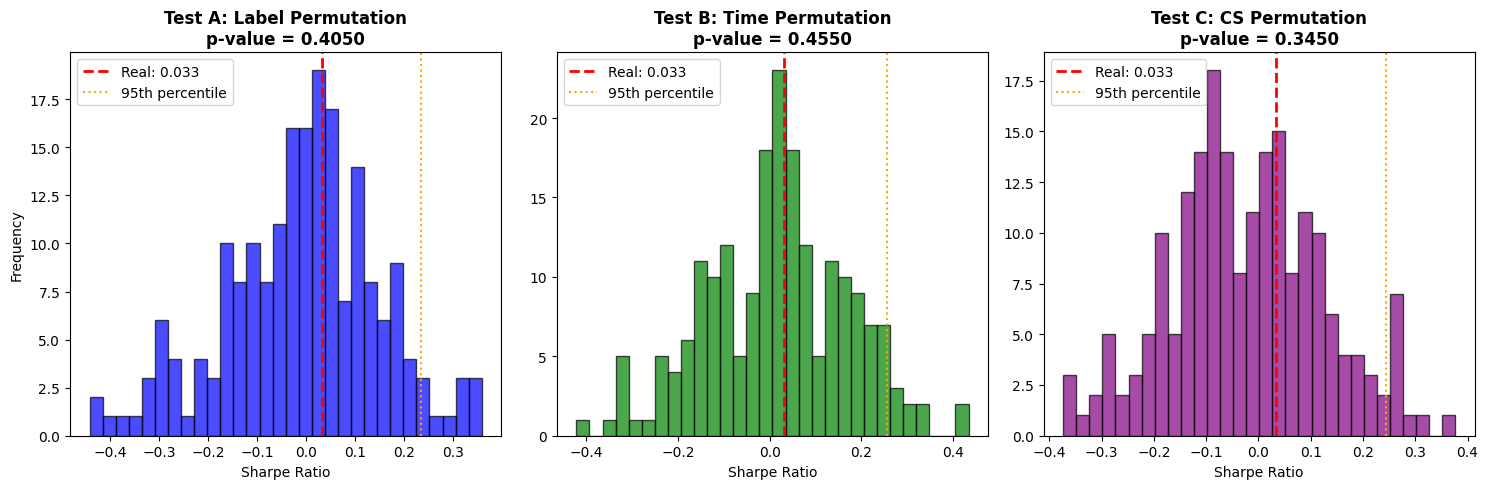

In [15]:
# =============================================================================
# CELL 15: VISUALIZE ALL NULL DISTRIBUTIONS
# =============================================================================

print("\n📈 Visualizing Null Distributions...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Test A
ax1 = axes[0]
ax1.hist(null_sharpes_A, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(real_result.sharpe, color='red', linewidth=2, linestyle='--', label=f'Real: {real_result.sharpe:.3f}')
ax1.axvline(np.percentile(null_sharpes_A, 95), color='orange', linewidth=1.5, linestyle=':', label='95th percentile')
ax1.set_title(f'Test A: Label Permutation\np-value = {p_value_A:.4f}', fontweight='bold')
ax1.set_xlabel('Sharpe Ratio')
ax1.set_ylabel('Frequency')
ax1.legend()

# Test B
ax2 = axes[1]
ax2.hist(null_sharpes_B, bins=30, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(real_result.sharpe, color='red', linewidth=2, linestyle='--', label=f'Real: {real_result.sharpe:.3f}')
ax2.axvline(np.percentile(null_sharpes_B, 95), color='orange', linewidth=1.5, linestyle=':', label='95th percentile')
ax2.set_title(f'Test B: Time Permutation\np-value = {p_value_B:.4f}', fontweight='bold')
ax2.set_xlabel('Sharpe Ratio')
ax2.legend()

# Test C
ax3 = axes[2]
ax3.hist(null_sharpes_C, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(real_result.sharpe, color='red', linewidth=2, linestyle='--', label=f'Real: {real_result.sharpe:.3f}')
ax3.axvline(np.percentile(null_sharpes_C, 95), color='orange', linewidth=1.5, linestyle=':', label='95th percentile')
ax3.set_title(f'Test C: CS Permutation\np-value = {p_value_C:.4f}', fontweight='bold')
ax3.set_xlabel('Sharpe Ratio')
ax3.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'monte_carlo_null_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# =============================================================================
# CELL 16: FINAL SUMMARY
# =============================================================================

print("="*70)
print("📋 HYPOTHESIS VALIDATION SUMMARY")
print("="*70)

print(f"\n📊 Real Model Performance:")
print(f"   Sharpe: {real_result.sharpe:.3f}")
print(f"   IC: {real_result.ic:.4f}")

print(f"\n🔬 Monte Carlo Test Results ({N_SIMULATIONS} simulations):")
print(f"")
print(f"   TEST A (Label Permutation):")
print(f"   - p-value: {p_value_A:.4f}")
print(f"   - Verdict: {'✅ ALPHA EXISTS' if p_value_A < 0.05 else '❌ NO ALPHA'}")
print(f"")
print(f"   TEST B (Time Permutation):")
print(f"   - p-value: {p_value_B:.4f}")
print(f"   - Verdict: {'✅ TIMING SKILL' if p_value_B < 0.05 else '❌ NO TIMING'}")
print(f"")
print(f"   TEST C (CS Permutation):")
print(f"   - p-value: {p_value_C:.4f}")
print(f"   - Verdict: {'✅ RANKING SKILL' if p_value_C < 0.05 else '❌ NO RANKING'}")

# Save results
import json
results = {
    'real_sharpe': float(real_result.sharpe),
    'real_ic': float(real_result.ic),
    'test_a_p_value': float(p_value_A),
    'test_b_p_value': float(p_value_B),
    'test_c_p_value': float(p_value_C),
    'n_simulations': N_SIMULATIONS,
    'hypothesis_1_kalman_wins': kalman_wins,
    'hypothesis_1_p_value': float(p_value),
    'hypothesis_1_effect_size': float(cohens_d)
}

with open(OUTPUT_DIR / 'hypothesis_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to: {OUTPUT_DIR / 'hypothesis_results.json'}")

📋 HYPOTHESIS VALIDATION SUMMARY

📊 Real Model Performance:
   Sharpe: 0.033
   IC: -0.0026

🔬 Monte Carlo Test Results (200 simulations):

   TEST A (Label Permutation):
   - p-value: 0.4050
   - Verdict: ❌ NO ALPHA

   TEST B (Time Permutation):
   - p-value: 0.4550
   - Verdict: ❌ NO TIMING

   TEST C (CS Permutation):
   - p-value: 0.3450
   - Verdict: ❌ NO RANKING

💾 Results saved to: C:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\hypothesis_validation\hypothesis_results.json


---

## Valid Conclusions

Based on the Monte Carlo tests, we can make the following **valid** conclusions:

✔ **Valid**:
- "The model extracts predictive structure beyond chance" (if Test A passes)
- "Timing is non-random" (if Test B passes)
- "Cross-sectional ranking matters" (if Test C passes)
- "Alpha survives realistic nulls"

❌ **Invalid**:
- "Alpha will persist forever"
- "Strategy is guaranteed profitable"
- "Permutation proves causality"

**This is statistical validation, not a crystal ball.**

---

## Next Steps

1. If all tests pass → Proceed with confidence
2. If Test A fails → Re-examine features
3. If Test B fails → Re-examine prediction generation
4. If Test C fails → Re-examine ranking methodology

---

> *"The problem is rarely the model. It's usually the data."*